In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # for interactive graphs
from collections import Counter
from sklearn.preprocessing import RobustScaler 
from sklearn.model_selection import StratifiedKFold

# Imbalance learning objects
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# To calculate precison-recall curve
from sklearn.metrics import auc, precision_recall_curve, plot_confusion_matrix

# For applying the algorithms
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

In [3]:
data = pd.read_csv("D:\\Dataset\\creditcardfraud\\creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# check for Null Values.
data.isnull().sum().max()

0

## Exploratory Data Analysis

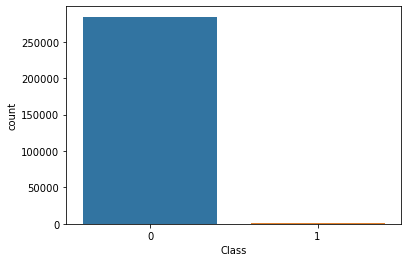

In [6]:
# class distribution
sns.countplot("Class", data=data)

The above graph clearly shows that the data is highly imbalance. Let us check the counts of valid and fraud transactions

In [7]:
valid_transactions = data[data['Class']==0]
fraud_transactions = data[data['Class']==1]
print(f'Total number of valid transactions: {len(valid_transactions)}')
print(f'Total number of fraud transactions: {len(fraud_transactions)}')

Total number of valid transactions: 284315
Total number of fraud transactions: 492


In [8]:
# useful information about the data
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
valid_transactions.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [10]:
fraud_transactions.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

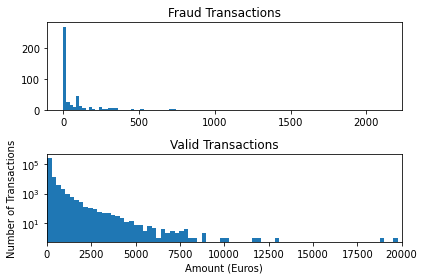

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1)
bins = 100
ax1.hist(fraud_transactions.Amount, bins = bins)
ax1.set_title('Fraud Transactions')
ax2.hist(valid_transactions.Amount, bins = bins)
ax2.set_title('Valid Transactions')
plt.xlabel('Amount (Euros)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.tight_layout()
plt.show()

The mean of the valid transactions is 88.29 Euros whereas the median(50% percentile) is 22 Euros. Likewise, the mean of fraud transactions is 122.21 Euros and the median is 9.25 Euros. Both of the transaction plots look right-skewed(right-tailed) that's why mean is higher than the median value. It looks strange that the maximum value of fraud transaction is only 2125.87 Euros however the valid one is 25K Euros.

Next, we analyze more about the transaction time against the withdrawal amounts.

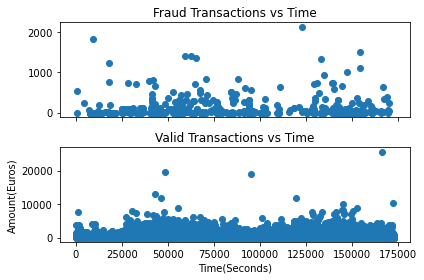

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.scatter(fraud_transactions.Time, fraud_transactions.Amount)
ax1.set_title("Fraud Transactions vs Time")
ax2.scatter(valid_transactions.Time, valid_transactions.Amount)
ax2.set_title("Valid Transactions vs Time")
plt.xlabel("Time(Seconds)")
plt.ylabel("Amount(Euros)")
plt.tight_layout()
plt.show()

Both fraud and valid transactions follow multi-modal distribution. It's hard to differentiate the classes based only upon the time and amount features.

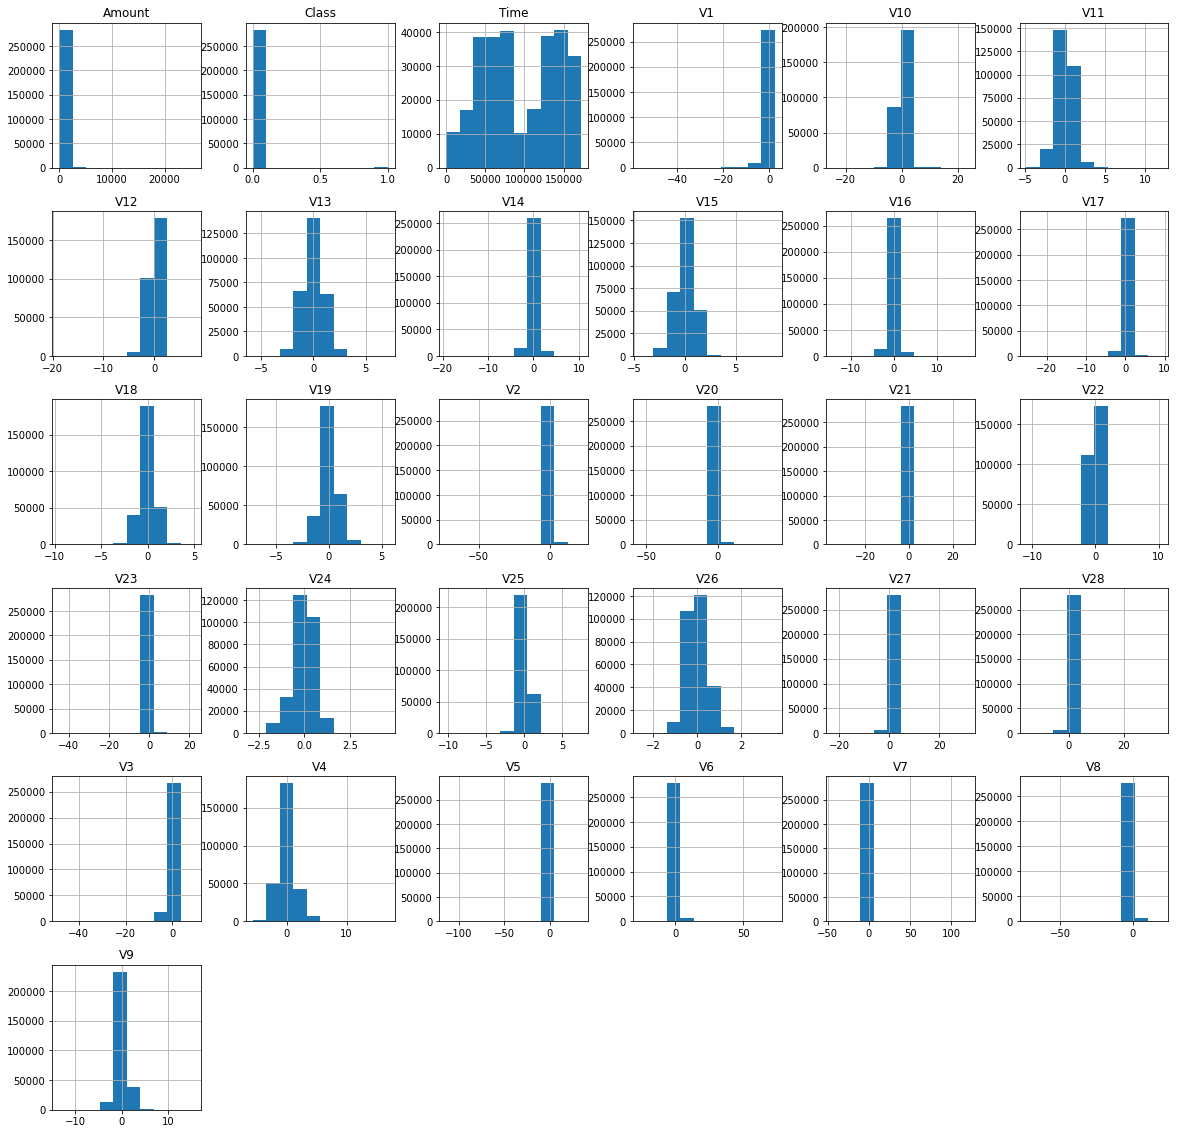

In [13]:
# plot the histogram of each parameter
data.hist(figsize=(20,20))
plt.show()

From the histogram plot, it is clear that the features from (V1-V28) are centered around zero mean due to PCA transformation. Therefore, the other features such as 'Time' and 'Amount' have to do the feature scaling before feeding the data to the machine learning models.

In [14]:
# Robust scaler
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#robustscaler

robust_scaler = RobustScaler()
scaled_amount = robust_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
scaled_time = robust_scaler.fit_transform(data['Time'].values.reshape(-1,1))

In [15]:
scaled_data = data.copy() # copy the original data
scaled_data.drop(['Amount', 'Time'], axis=1, inplace=True)
scaled_data.insert(0, 'scaled_time', scaled_time)
scaled_data.insert(1, 'scaled_amount', scaled_amount)
scaled_data.head()

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.994983,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.994983,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-0.994972,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.994972,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.994960,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


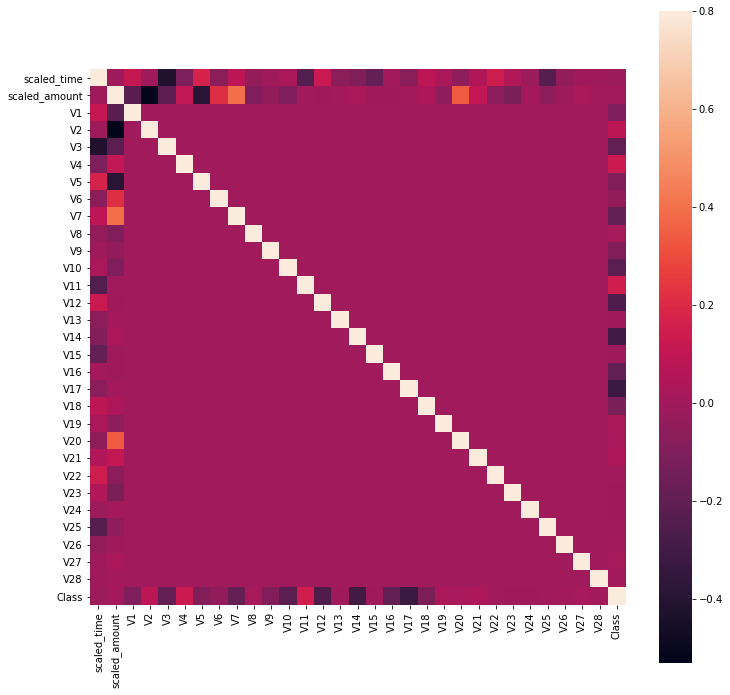

In [16]:
# Correlation matrix after scaling
correlation_mat = scaled_data.corr()
fig = plt.figure(figsize=(12,12))
sns.heatmap(correlation_mat, vmax=0.8, square=True)
plt.show()

From the centre of heat map, we can see that the features(v1 to v28) are not correlated.Therefore, we don't have to further reduce the dimensionality of the data. If we see the Class row, some of the features such as v12, v14, v17 are negatively correlated whereas the features such as v2 and v11 are positively correlated.

In [17]:
# Get all the columns from the dataframe
columns = scaled_data.columns.tolist()

# filter the column we want to predict
target = "Class"
columns = [c for c in columns if c not in target]
scaled_x = scaled_data[columns]
scaled_y = scaled_data[target]
print(f'The shape of training data: {scaled_x.shape}')
print(f'The shape of Class label  : {scaled_y.shape}')

The shape of training data: (284807, 30)
The shape of Class label  : (284807,)


### Methods and Mistakes when dealing with imbalanced data:
- Use Precision and Recall curve as a metric when the positive class(Fraud) is important.
- Use ROC as a metric when both the classes are important
- Do not over-sample before k-fold cross-validation
- Do not do feature selection before cross-validation
- Don't test on resampled data
- Use stratified k-folds
    
[Source: Kaggle Kernel](https://www.kaggle.com/lane203j/methods-and-common-mistakes-for-evaluating-models)

In [18]:
# Stratified sampling - split
skf = StratifiedKFold(n_splits = 5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(scaled_x,scaled_y):
    print("Train Index: {}, Test Index: {}".format(train_index, test_index))
    scaled_x_train, scaled_x_test = scaled_x.iloc[train_index], scaled_x.iloc[test_index]
    scaled_y_train, scaled_y_test = scaled_y.iloc[train_index], scaled_y.iloc[test_index]
    
# Convert in to array

scaled_x_train_arr = scaled_x_train.values
scaled_y_train_arr = scaled_y_train.values
scaled_x_test_arr  = scaled_x_test.values
scaled_y_test_arr  = scaled_y_test.values

# check both the train and test label distribution are distributed in the same of original data

train_unique_y, train_count_y = np.unique(scaled_y_train_arr, return_counts=True)
test_unique_y,  test_count_y = np.unique(scaled_y_test_arr, return_counts= True)

print("Train data distribution: {}".format(train_count_y / len(scaled_x_train_arr)))
print("Test data distribution: {}".format(test_count_y / len(scaled_y_test_arr)))

print("Train data count: {}".format(Counter(scaled_y_train)))
print("Test data count: {}".format(Counter(scaled_y_test)))


Train Index: [ 30473  30496  31002 ... 284804 284805 284806], Test Index: [    0     1     2 ... 57017 57018 57019]
Train Index: [     0      1      2 ... 284804 284805 284806], Test Index: [ 30473  30496  31002 ... 113964 113965 113966]
Train Index: [     0      1      2 ... 284804 284805 284806], Test Index: [ 81609  82400  83053 ... 170946 170947 170948]
Train Index: [     0      1      2 ... 284804 284805 284806], Test Index: [150654 150660 150661 ... 227866 227867 227868]
Train Index: [     0      1      2 ... 227866 227867 227868], Test Index: [212516 212644 213092 ... 284804 284805 284806]
Train data distribution: [0.99827076 0.00172924]
Test data distribution: [0.99827952 0.00172048]
Train data count: Counter({0: 227452, 1: 394})
Test data count: Counter({0: 56863, 1: 98})


### Difference among the KFold, Stratified KFold and Stratified Shuffle Split

[stratifiedkfold-v-s-kfold-v-s-stratifiedshufflesplit](https://medium.com/@xzz201920/stratifiedkfold-v-s-kfold-v-s-stratifiedshufflesplit-ffcae5bfdf)

[difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn](https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn)


In [19]:
def precision_recall_auc_score(clf, x, y):
    '''It computes the precision and recall under curve'''
    precisions, recalls, _ = precision_recall_curve(y, clf.predict_proba(x)[:,1], pos_label=1)
    
    return auc(recalls, precisions)

In [20]:
def calculate_confusion_matrix(clf, x, y):
    
    return confusion_matrix(y, clf.predict(x))

In [21]:
def imbalanced_cross_validation_score(clf, x, y, cv, scoring):
    '''
        This function computes the cross-validation score of a given 
        classifier using a choice of sampling function to mitigate 
        the class imbalance, and stratified k-fold sampling.
        
        The first five arguments are the same as 
        sklearn.model_selection.cross_val_score.
        
        - clf.predict_proba(x) returns class label probabilities
        - clf.fit(x,y) trains the model
        
        - x = data
        
        - y = labels
        
        - cv = the number of folds in the cross validation
        
        - scoring(classifier, x, y) returns a float
        
        The last argument is a choice of random sampler: an object 
        similar to the sampler objects available from the python 
        package imbalanced-learn. In particular, this 
        object needs to have the method:
        
        sampler.fit_sample(x,y)
        
        See http://contrib.scikit-learn.org/imbalanced-learn/
        for more details and examples of other sampling objects 
        available.  
    
    '''
    
    cv_score = 0.
    train_score = 0.
    test_score = 0.
    
    # stratified k-fold creates folds with the same ratio of positive 
    # and negative samples as the entire dataset.
    
    skf = StratifiedKFold(n_splits=cv, random_state=42, shuffle=True)
    
    for train_idx, test_idx in skf.split(x,y):
        print("Train Index: {}, Test Index: {}".format(train_idx[:5], test_idx[:5]))
        
        xfold_train_sampled, yfold_train_sampled = x.iloc[train_idx],y.iloc[train_idx]
        clf.fit(xfold_train_sampled, yfold_train_sampled)
        
        train_score = scoring(clf, xfold_train_sampled, yfold_train_sampled)
        val_score  = scoring(clf, x.iloc[test_idx], y.iloc[test_idx])
        
        print("Train AUPRC: %.2f Val AUPRC: %.2f"%(train_score,val_score))

        cv_score += val_score
        
    return cv_score/cv

### Random Undersampling

This technique selects the samples randomly from the majority class which will be equal to/ more than the size of the minority class. It is one of the naive sub-sampling method. Since the number of valid transactions is 577x higher than the fraud transactions, it causes the huge information loss of the valid transactions.

[other undersampling methods](https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.under_sampling._prototype_selection)

In [22]:
undersample = RandomUnderSampler(sampling_strategy=0.5)
undersampled_x, undersampled_y = undersample.fit_resample(scaled_x_train, scaled_y_train)
print("Undersample data count: {}".format(Counter(undersampled_y)))

Undersample data count: Counter({0: 788, 1: 394})


In [23]:
print("Random Undersampling: CV Imbalance score")
print("Using Logistic Regression")
logistic_clf = LogisticRegression()
cv_score = imbalanced_cross_validation_score(logistic_clf, undersampled_x, undersampled_y, 5, precision_recall_auc_score)
print("Cross-validated AUPRC score: %.2f"%cv_score)
# Test score calculation
test_score = precision_recall_auc_score(logistic_clf, scaled_x_test, scaled_y_test)
print("Test AUPRC: %.2f"%(test_score))

Random Undersampling: CV Imbalance score
Using Logistic Regression
Train Index: [0 2 3 4 5], Test Index: [ 1  9 15 24 34]
Train AUPRC: 0.99 Val AUPRC: 0.96
Train Index: [0 1 6 7 9], Test Index: [2 3 4 5 8]
Train AUPRC: 0.98 Val AUPRC: 0.98
Train Index: [0 1 2 3 4], Test Index: [ 7 13 17 18 21]
Train AUPRC: 0.98 Val AUPRC: 0.97
Train Index: [1 2 3 4 5], Test Index: [ 0  6 16 20 23]
Train AUPRC: 0.98 Val AUPRC: 0.98
Train Index: [0 1 2 3 4], Test Index: [10 19 22 29 31]
Train AUPRC: 0.98 Val AUPRC: 0.98
Cross-validated AUPRC score: 0.97
Test AUPRC: 0.76


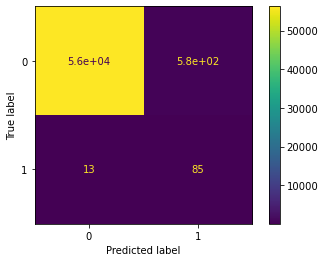

In [24]:
# plotting the confusion matrix for logistic regression
plot_confusion_matrix(logistic_clf, scaled_x_test, scaled_y_test)

### Some key XGBoost hyperparameters are:

* learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
* max_depth: determines how deeply each tree is allowed to grow during any boosting round.
* subsample: percentage of samples used per tree. Low value can lead to underfitting.
* colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
* n_estimators: number of trees you want to build.
* objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.

### Regularization parameters:
* gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
* alpha: L1 regularization on leaf weights. A large value leads to more regularization.
* lambda: L2 regularization on leaf weights and is smoother than L1 regularization.

[XGBoost-Hyperparams](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters)

In [27]:
print("Random Undersampling: CV Imbalance score")
print("Using XGBoost")
xgb_clf = XGBClassifier(max_depth=3, n_estimators=200, learning_rate=0.001, subsample=0.25, objective='binary:logistic')
cv_score = imbalanced_cross_validation_score(xgb_clf, undersampled_x, undersampled_y, 5, precision_recall_auc_score)
print("Cross-validated AUPRC score: %.2f"%cv_score)
# Test score calculation
test_score = precision_recall_auc_score(xgb_clf, scaled_x_test, scaled_y_test)
print("Test AUPRC: %.2f"%(test_score))

Random Undersampling: CV Imbalance score
Using XGBoost
Train Index: [0 2 3 4 5], Test Index: [ 1  9 15 24 34]
Train AUPRC: 0.98 Val AUPRC: 0.97
Train Index: [0 1 6 7 9], Test Index: [2 3 4 5 8]
Train AUPRC: 0.98 Val AUPRC: 0.97
Train Index: [0 1 2 3 4], Test Index: [ 7 13 17 18 21]
Train AUPRC: 0.98 Val AUPRC: 0.98
Train Index: [1 2 3 4 5], Test Index: [ 0  6 16 20 23]
Train AUPRC: 0.98 Val AUPRC: 0.98
Train Index: [0 1 2 3 4], Test Index: [10 19 22 29 31]
Train AUPRC: 0.99 Val AUPRC: 0.96
Cross-validated AUPRC score: 0.97
Test AUPRC: 0.78


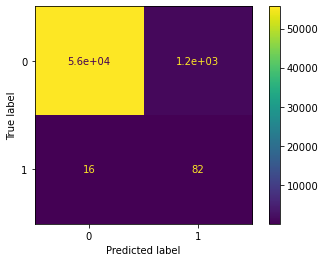

In [28]:
# plotting the confusion matrix for XGBoost classifier
plot_confusion_matrix(xgb_clf, scaled_x_test, scaled_y_test)

Both Extreme Gradient Boost classifier and Logistic Regression overfits with the training data. From the confusion matrix, it clears that false Positives of XGBoost is higher than logistic regression.

### Random Oversampling

This technique duplicates the samples from the minority class in the training set. It is one of the effective approaches to train the machine learning model in the imbalance dataset problem.

[other oversampling methods](https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.over_sampling)

In [30]:
oversampler = SMOTE(sampling_strategy=0.5)
oversampled_x, oversampled_y = oversampler.fit_resample(scaled_x_train, scaled_y_train)
print("Undersample data count: {}".format(Counter(oversampled_y)))

Undersample data count: Counter({0: 227452, 1: 113726})


In [31]:
# Logistic regression with Oversampling data
print("Random Oversampling")
logistic_clf = LogisticRegression(random_state=42)
score = imbalanced_cross_validation_score(logistic_clf, oversampled_x, oversampled_y, 5, precision_recall_auc_score)
print("Cross-validated AUPRC score: %.2f"%score)
# Test score calculation
test_score = precision_recall_auc_score(logistic_clf, scaled_x_test, scaled_y_test)
print("Test AUPRC: %.2f"%(test_score))

Random Oversampling
Train Index: [1 2 3 4 5], Test Index: [ 0  8 13 17 21]
Train AUPRC: 0.98 Val AUPRC: 0.99
Train Index: [0 2 3 4 5], Test Index: [ 1 10 12 29 30]
Train AUPRC: 0.98 Val AUPRC: 0.98
Train Index: [0 1 3 4 5], Test Index: [ 2  6 11 14 25]
Train AUPRC: 0.98 Val AUPRC: 0.98
Train Index: [0 1 2 3 4], Test Index: [ 5  7 16 19 20]
Train AUPRC: 0.98 Val AUPRC: 0.98
Train Index: [0 1 2 5 6], Test Index: [ 3  4  9 15 18]
Train AUPRC: 0.98 Val AUPRC: 0.98
Cross-validated AUPRC score: 0.98
Test AUPRC: 0.77


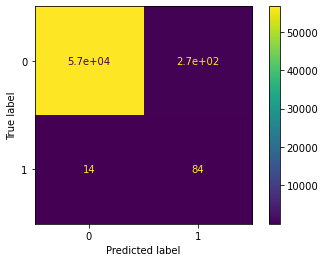

In [32]:
# plotting the confusion matrix for logistic regression
plot_confusion_matrix(logistic_clf, scaled_x_test, scaled_y_test)

In [33]:
print("SMOTE Oversampling: Cross Validation Imbalance score")
print("Using XGBoost")
xgb_clf = XGBClassifier(max_depth=3, n_estimators=200, learning_rate=0.001, subsample=0.25, objective='binary:logistic')
cv_score = imbalanced_cross_validation_score(xgb_clf, oversampled_x, oversampled_y, 5, precision_recall_auc_score)
print("Cross-validated AUPRC score: %.2f"%cv_score)
# Test score calculation
test_score = precision_recall_auc_score(xgb_clf, scaled_x_test, scaled_y_test)
print("Test AUPRC: %.2f"%(test_score))

SMOTE Oversampling: Cross Validation Imbalance score
Using XGBoost
Train Index: [1 2 3 4 5], Test Index: [ 0  8 13 17 21]
Train AUPRC: 0.97 Val AUPRC: 0.97
Train Index: [0 2 3 4 5], Test Index: [ 1 10 12 29 30]
Train AUPRC: 0.97 Val AUPRC: 0.97
Train Index: [0 1 3 4 5], Test Index: [ 2  6 11 14 25]
Train AUPRC: 0.97 Val AUPRC: 0.97
Train Index: [0 1 2 3 4], Test Index: [ 5  7 16 19 20]
Train AUPRC: 0.97 Val AUPRC: 0.97
Train Index: [0 1 2 5 6], Test Index: [ 3  4  9 15 18]
Train AUPRC: 0.97 Val AUPRC: 0.97
Cross-validated AUPRC score: 0.97
Test AUPRC: 0.76


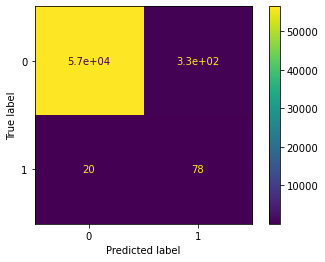

In [34]:
# plotting the confusion matrix for XGBoost classifier
plot_confusion_matrix(xgb_clf, scaled_x_test, scaled_y_test)

Oversampler reduces the false Positives in the prediction of both the classifiers but increased the false negatives that's why the precison-recall-score is poor comparative to the undersampler-classifiers.

Refererences: <br>
1.[Understanding AUC and ROC curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) <br>
2.[Dealing with Imbalanced data](https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation) <br>
3.[ROC curves and Precision Recalls curves](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)